### Pipeline 2 — PCA → GRU Encoder (pre-entreno) → TCN

- El pre-entreno guardó:
  - scaler_trainonly.joblib
  - pca_trainonly.joblib
  - gru_autoencoder_pca_trainonly_best.pt 



In [6]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")

#Unión
df["Timestamp"] = ts_df["Timestamp"].values
#Ordenar 
df = df.sort_values("Timestamp").reset_index(drop=True)

df: (2830539, 73) | ts_df: (2830539, 1)
Timestamp -> nulos: 0 | dtype: datetime64[ns]
0   2017-07-03 01:00:01
1   2017-07-03 01:00:01
2   2017-07-03 01:00:01
Name: Timestamp, dtype: datetime64[ns]
2830536   2017-07-07 12:59:00
2830537   2017-07-07 12:59:00
2830538   2017-07-07 12:59:00
Name: Timestamp, dtype: datetime64[ns]


In [ ]:
#X Y
y = df["Attack"].astype(np.int64).values
X_df = df.select_dtypes(include=[np.number]).copy()

X_df: (2830539, 71) | y: (2830539,)
Attack bincount: [2272894  557645]


In [ ]:
#Split temporal (70/15/15)
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print("X:", X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("y:", y_train.shape, y_val.shape, y_test.shape)
print("train bincount:", np.bincount(y_train), " | val:", np.bincount(y_val), " | test:", np.bincount(y_test))

X: (1981377, 71) (424581, 71) (424581, 71)
y: (1981377,) (424581,) (424581,)
train bincount: [1714580  266797]  | val: [264157 160424]  | test: [294157 130424]


In [ ]:
# Cargar scaler + PCA (pre-entreno) y transformar
import joblib

scaler = joblib.load("scaler_trainonly.joblib")
pca    = joblib.load("pca_trainonly.joblib")

X_train_pca = pca.transform(scaler.transform(X_train_df))
X_val_pca   = pca.transform(scaler.transform(X_val_df))
X_test_pca  = pca.transform(scaler.transform(X_test_df))

print("PCA shapes:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
print("NaNs PCA:", np.isnan(X_train_pca).sum(), np.isnan(X_val_pca).sum(), np.isnan(X_test_pca).sum())

PCA shapes: (1981377, 26) (424581, 26) (424581, 26)
NaNs PCA: 0 0 0


### Ventanas temporales (secuencias)

Convertimos el flujo tabular en ventanas de longitud 20.

- La etiqueta de la ventana es la del último flujo de la ventana (clasificación "a futuro" dentro de la ventana).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

WINDOW_SIZE = 20
STRIDE = 5

def make_window_starts(n, window_size, stride):
    
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset(Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_starts(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

train_ds = SeqWindowBinaryDataset(X_train_pca, y_train, WINDOW_SIZE, STRIDE)
val_ds   = SeqWindowBinaryDataset(X_val_pca,   y_val,   WINDOW_SIZE, STRIDE)
test_ds  = SeqWindowBinaryDataset(X_test_pca,  y_test,  WINDOW_SIZE, STRIDE)

print("windows:", len(train_ds), len(val_ds), len(test_ds))

windows: 396272 84913 84913


In [ ]:
def window_labels_last(y_flow, window_size, stride):
    y_flow = np.asarray(y_flow, dtype=np.int64)
    starts = make_window_starts(len(y_flow), window_size, stride)
    return np.array([y_flow[s + window_size - 1] for s in starts], dtype=np.int64)

y_train_w = window_labels_last(y_train, WINDOW_SIZE, STRIDE)
counts_w = np.bincount(y_train_w, minlength=2)
print("train window bincount:", counts_w)

class_weights = 1.0 / np.maximum(counts_w, 1)
sample_weights = class_weights[y_train_w]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 256  

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("batches:", len(train_loader), len(val_loader), len(test_loader))

train window bincount: [342971  53301]
batches: 1547 332 332


### Modelo: GRU Encoder congelado + TCN + capa final

- Cargamos el encoder del autoencoder GRU pre-entrenado.
- TCN


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cpu")

D_PCA = X_train_pca.shape[1]
H = 64  #hidden size del encoder

#encoder con la misma arquitectura que en el pre-entreno
encoder = nn.GRU(input_size=D_PCA, hidden_size=H, batch_first=True).to(device)

state = torch.load("gru_autoencoder_pca_trainonly_best.pt", map_location=device)

enc_state = {k.replace("encoder.", ""): v for k, v in state.items() if k.startswith("encoder.")}
encoder.load_state_dict(enc_state, strict=True)
encoder.eval()

for p in encoder.parameters():#Congelar encoder
    p.requires_grad = False


Encoder cargado y congelado.


In [ ]:
#TCN (causal) + clasificador
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.drop1(F.relu(self.chomp1(self.conv1(x))))
        out = self.drop2(F.relu(self.chomp2(self.conv2(out))))
        res = x if self.downsample is None else self.downsample(x)
        return F.relu(out + res)

class TCNBinaryClassifier(nn.Module):
    def __init__(self, in_ch, channels=(64, 64, 64), kernel_size=3, dropout=0.2, n_classes=2):
        super().__init__()
        layers = []
        ch_in = in_ch
        for i, ch_out in enumerate(channels):
            dil = 2 ** i
            layers.append(TemporalBlock(ch_in, ch_out, kernel_size, dil, dropout))
            ch_in = ch_out
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(ch_in, n_classes)

    def forward(self, x_seq):
        # x_seq: (B, T, H)
        x = x_seq.transpose(1, 2)  # (B, H, T)
        y = self.tcn(x)            # (B, C, T)
        last = y[:, :, -1]         # (B, C)
        return self.fc(last)       # (B, 2)

tcn_head = TCNBinaryClassifier(in_ch=H, channels=(64, 64, 64), kernel_size=3, dropout=0.2, n_classes=2).to(device)
print(tcn_head)

TCNBinaryClassifier(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (drop2): Dropout(p=0.2, inplace=False)
    )
    (1): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp2): Chomp1d()
      (drop2): Dropout(p=0.2, inplace=False)
    )
    (2): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (ch

In [ ]:
#Loss + optimizer

counts_w = np.bincount(y_train_w, minlength=2)
w = 1.0 / np.maximum(counts_w, 1)
w = w / w.sum() * 2
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

optimizer = torch.optim.AdamW(tcn_head.parameters(), lr=3e-4, weight_decay=1e-4)
print("class_weights:", w)

class_weights: [0.26901219 1.73098781]


In [ ]:
#Train / Eval loops 
from sklearn.metrics import average_precision_score, f1_score, balanced_accuracy_score, matthews_corrcoef

def predict_proba(loader):
    encoder.eval()
    tcn_head.eval()
    ys, prob_attack = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out_seq, _ = encoder(xb)              # (B, T, H)
            logits = tcn_head(out_seq)            # (B, 2)
            probs = torch.softmax(logits, dim=1)  # (B, 2)
            ys.append(yb.numpy())
            prob_attack.append(probs[:, 1].cpu().numpy())
    y_true = np.concatenate(ys)
    p1 = np.concatenate(prob_attack)
    y_pred = (p1 >= 0.5).astype(np.int64)
    return y_true, y_pred, p1

def run_epoch(train=True):
    if train:
        tcn_head.train()
    else:
        tcn_head.eval()

    total_loss = 0.0
    total = 0
    correct = 0

    loader = train_loader if train else val_loader

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.set_grad_enabled(train):
            out_seq, _ = encoder(xb)
            logits = tcn_head(out_seq)
            loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(tcn_head.parameters(), 1.0)
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(logits, dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

    return total_loss / max(total, 1), correct / max(total, 1)

EPOCHS = 8
best_val_ap = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train=True)
    va_loss, va_acc = run_epoch(train=False)

    yv, yv_pred, yv_p1 = predict_proba(val_loader)
    val_ap = average_precision_score(yv, yv_p1)  # AP para clase Attack (positiva)

    print(f"Epoch {epoch}/{EPOCHS} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f} | VAL AP(Attack)={val_ap:.4f}")

    if val_ap > best_val_ap:
        best_val_ap = val_ap
        best_state = {k: v.cpu().clone() for k, v in tcn_head.state_dict().items()}

print("Best VAL AP(Attack):", best_val_ap)

Epoch 1/8 | train loss=0.1338 acc=0.9122 | val loss=0.8966 acc=0.7351 | VAL AP(Attack)=0.5359
Epoch 2/8 | train loss=0.1136 acc=0.9365 | val loss=1.0258 acc=0.6218 | VAL AP(Attack)=0.5116
Epoch 3/8 | train loss=0.1052 acc=0.9423 | val loss=0.8210 acc=0.7544 | VAL AP(Attack)=0.6466
Epoch 4/8 | train loss=0.0990 acc=0.9453 | val loss=0.8983 acc=0.7402 | VAL AP(Attack)=0.6087
Epoch 5/8 | train loss=0.0939 acc=0.9478 | val loss=0.8910 acc=0.7574 | VAL AP(Attack)=0.6420
Epoch 6/8 | train loss=0.0907 acc=0.9508 | val loss=0.8423 acc=0.7578 | VAL AP(Attack)=0.6576
Epoch 7/8 | train loss=0.0880 acc=0.9526 | val loss=0.8183 acc=0.7689 | VAL AP(Attack)=0.6769
Epoch 8/8 | train loss=0.0859 acc=0.9546 | val loss=0.8390 acc=0.7706 | VAL AP(Attack)=0.7008
Best VAL AP(Attack): 0.7008067394148463


In [ ]:
#TEST (threshold=0.5)
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

tcn_head.load_state_dict(best_state)
tcn_head.to(device)

y_true, y_pred, p1 = predict_proba(test_loader)

f1_macro = f1_score(y_true, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
ap_attack = average_precision_score(y_true, p1)

print("TEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", ap_attack)

print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

TEST metrics
F1 macro: 0.941878005223491
Balanced Accuracy: 0.9572873718427528
MCC: 0.8873019356108054
PR-AUC (Attack): 0.987859877884341

Classification report:
               precision    recall  f1-score   support

           0     0.9902    0.9355    0.9621     58826
           1     0.8707    0.9791    0.9217     26087

    accuracy                         0.9489     84913
   macro avg     0.9304    0.9573    0.9419     84913
weighted avg     0.9535    0.9489    0.9497     84913

Confusion matrix:
 [[55032  3794]
 [  546 25541]]


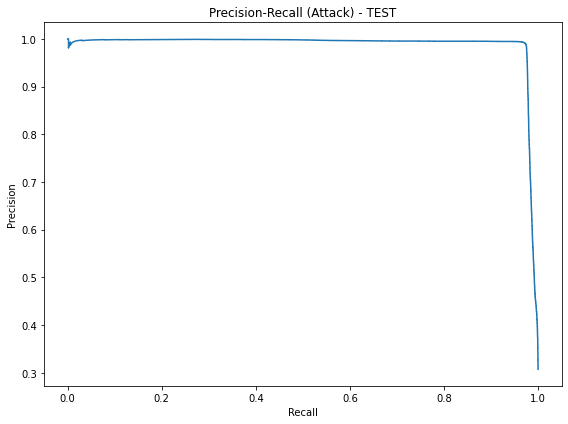

In [ ]:
#Curva Precision-Recall (Attack) en TEST
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_true, p1)

plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [ ]:
#Guardar artefactos (head + métricas)
import json

torch.save(tcn_head.state_dict(), "tcn_binary_head_best.pt")

metrics = {
    "best_val_ap_attack": float(best_val_ap),
    "test_f1_macro": float(f1_macro),
    "test_balanced_accuracy": float(bal_acc),
    "test_mcc": float(mcc),
    "test_pr_auc_attack": float(ap_attack),
    "confusion_matrix": cm.tolist()
}

with open("metrics_pipeline2_binary.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("Guardado: tcn_binary_head_best.pt, metrics_pipeline2_binary.json")

Guardado: tcn_binary_head_best.pt, metrics_pipeline2_binary.json
